Опускаю шаги, которые не привели к положительному результату при анализе данных (например кросс-валидацию, перебор фич для исключения, замену значений в переменной tartar на числовые, чтобы отказаться от категориальных данных и т.п.)

In [1]:
# импортируем библиотеки
import pandas as pd
from phik.report import plot_correlation_matrix
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
    classification_report, roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('dark_background')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# грузим данные для тестирования
df = pd.read_csv('/kaggle/input/leopard-challenge-classification/train.csv')
df.head()

,ID,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking
0,2791,65,170,75,91.0,0.6,0.9,1.0,1.0,122.0,...,14.0,3.0,1.2,20.0,16.0,122.0,Y,0,N,0
1,18280,35,170,85,97.0,1.5,1.5,1.0,1.0,138.0,...,14.6,1.0,0.7,20.0,25.0,40.0,Y,0,Y,1
2,1618,70,165,55,75.0,0.8,1.0,1.0,1.0,115.0,...,14.7,1.0,0.7,15.0,13.0,19.0,Y,0,Y,0
3,16856,35,180,85,83.0,1.2,1.0,1.0,1.0,130.0,...,17.2,1.0,0.8,22.0,18.0,17.0,Y,0,Y,0
4,5885,25,170,65,80.0,1.5,1.2,1.0,1.0,135.0,...,16.5,1.0,1.0,20.0,13.0,14.0,Y,0,Y,1


In [3]:
# смотрим на не числовые переменные
df.select_dtypes(include='object').head()

,oral,tartar
0,Y,N
1,Y,Y
2,Y,Y
3,Y,Y
4,Y,Y


In [4]:
# проверяем, что у oral только 1 значение
df['oral'].nunique()

1

In [5]:
df.isna().mean() # доля nan в фичах - пропусков нет

ID                     0.0
age                    0.0
height(cm)             0.0
weight(kg)             0.0
waist(cm)              0.0
eyesight(left)         0.0
eyesight(right)        0.0
hearing(left)          0.0
hearing(right)         0.0
systolic               0.0
relaxation             0.0
fasting blood sugar    0.0
Cholesterol            0.0
triglyceride           0.0
HDL                    0.0
LDL                    0.0
hemoglobin             0.0
Urine protein          0.0
serum creatinine       0.0
AST                    0.0
ALT                    0.0
Gtp                    0.0
oral                   0.0
dental caries          0.0
tartar                 0.0
smoking                0.0
dtype: float64

In [6]:
# смотрим матрицу корреляции
df.corr()

/tmp/ipykernel_20/3349862606.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,ID,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
ID,1.000000,0.004467,-0.001078,0.006905,0.000915,0.019467,-0.005512,0.002590,-0.001871,0.005763,...,-0.000192,0.009282,0.009691,-0.018633,0.010453,0.014714,0.000582,0.006855,-0.008004,0.007011
age,0.004467,1.000000,-0.431568,-0.250177,0.076083,-0.170394,-0.172827,0.236021,0.235824,0.201221,...,-0.076630,0.003464,-0.231677,0.071429,0.053950,0.036391,-0.040013,0.086933,-0.091599,-0.014082
height(cm),-0.001078,-0.431568,1.000000,0.518707,0.172743,0.081783,0.097934,-0.110418,-0.110214,-0.048165,...,0.003143,-0.011854,0.124091,-0.030560,0.001445,-0.029163,0.021204,-0.049456,0.025595,0.026243
weight(kg),0.006905,-0.250177,0.518707,1.000000,0.790746,0.065145,0.078283,-0.073121,-0.066403,0.194841,...,-0.229017,0.074267,0.198819,0.026057,0.025051,0.095974,0.197703,0.111016,0.027117,0.011526
waist(cm),0.000915,0.076083,0.172743,0.790746,1.000000,-0.017764,0.005589,0.014217,0.017967,0.255932,...,-0.287922,0.088632,0.137844,0.065020,0.020510,0.125552,0.216630,0.190571,0.008492,0.015579
eyesight(left),0.019467,-0.170394,0.081783,0.065145,-0.017764,1.000000,0.304132,-0.055929,-0.044965,-0.030349,...,0.016090,0.009130,0.043432,-0.033107,-0.010836,-0.012362,0.007998,-0.027654,-0.012164,-0.010562
eyesight(right),-0.005512,-0.172827,0.097934,0.078283,0.005589,0.304132,1.000000,-0.054243,-0.068271,-0.032952,...,0.005374,-0.005279,0.035869,-0.019487,-0.022052,-0.013344,0.014579,-0.016073,0.004151,-0.008161
hearing(left),0.002590,0.236021,-0.110418,-0.073121,0.014217,-0.055929,-0.054243,1.000000,0.538608,0.062347,...,-0.022307,-0.030399,-0.079575,0.024389,-0.002768,0.005198,0.010252,-0.002476,-0.015491,-0.024554
hearing(right),-0.001871,0.235824,-0.110214,-0.066403,0.017967,-0.044965,-0.068271,0.538608,1.000000,0.056581,...,-0.007806,-0.024716,-0.076951,0.025553,0.001311,0.007581,0.014879,0.006667,-0.030897,-0.018433
systolic,0.005763,0.201221,-0.048165,0.194841,0.255932,-0.030349,-0.032952,0.062347,0.056581,1.000000,...,-0.039884,0.019307,0.052628,0.060140,-0.015528,0.070660,0.069009,0.147245,0.006192,-0.010530


In [7]:
# строим зависимость по Фику
phik_overview = df.phik_matrix()
phik_overview['smoking'].sort_values(ascending=False)

/opt/conda/lib/python3.10/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable oral for analysis 1. Dropping this column
  warnings.warn(


interval columns not set, guessing: ['ID', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries', 'smoking']


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


smoking                1.000000
triglyceride           0.190617
age                    0.183296
Gtp                    0.142844
hemoglobin             0.112074
tartar                 0.104470
dental caries          0.089124
waist(cm)              0.062522
serum creatinine       0.055594
HDL                    0.050773
weight(kg)             0.042934
fasting blood sugar    0.041979
hearing(left)          0.035270
height(cm)             0.035266
Urine protein          0.030645
hearing(right)         0.024719
relaxation             0.023451
LDL                    0.022210
systolic               0.016464
Cholesterol            0.015907
ALT                    0.014651
AST                    0.001957
eyesight(right)        0.000000
eyesight(left)         0.000000
ID                     0.000000
Name: smoking, dtype: float64

In [8]:
# смотрим стреднюю, курящих примерно 1/5, можно сказать, что классы 
# курящих/некурящих в значительной степени не сбалансированы
df['smoking'].mean()

0.20197648416648634

In [9]:
# делим выборку на тренировочную и валидационную
train, val = train_test_split(df, train_size=0.7, random_state=42)

In [10]:
# в ходе анализа датасета пришёл к выводу об избыточности переменных - 
# 'oral', 'relaxation','hearing(right), - исключаем их
X = ['ID', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'systolic',
       'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'tartar']
cat_features = ['tartar']
y = ['smoking']

In [11]:
# объединяем в пул фичи для кэтбуст
train_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features)
valid_data = Pool(data=val[X],
                  label=val[y], 
                  cat_features=cat_features)

In [12]:
# задаём параметры
params = {'eval_metric': 'F1',
          'loss_function': 'Logloss',
          'verbose':180,
          'random_seed':42,
          'auto_class_weights':'Balanced',
          'learning_rate':0.01}
model = CatBoostClassifier(**params)

In [13]:
# обучаем модель
model.fit(train_data, eval_set=valid_data)

0:	learn: 0.5659407	test: 0.5320804	best: 0.5320804 (0)	total: 62.9ms	remaining: 1m 2s
180:	learn: 0.6527156	test: 0.6152726	best: 0.6158427 (179)	total: 1.01s	remaining: 4.56s
360:	learn: 0.6861229	test: 0.6144829	best: 0.6209044 (320)	total: 1.83s	remaining: 3.24s
540:	learn: 0.7079180	test: 0.6194759	best: 0.6215829 (489)	total: 2.65s	remaining: 2.25s
720:	learn: 0.7278580	test: 0.6208283	best: 0.6231276 (628)	total: 3.52s	remaining: 1.36s
900:	learn: 0.7387098	test: 0.6193924	best: 0.6253475 (750)	total: 4.37s	remaining: 480ms
999:	learn: 0.7510700	test: 0.6183249	best: 0.6253475 (750)	total: 4.83s	remaining: 0us

bestTest = 0.6253474577
bestIteration = 750

Shrink model to first 751 iterations.


In [14]:
model.best_iteration_

750

In [15]:
# теперь применим на всей выборке
train_data = Pool(data=df[X],
                  label=df[y],
                  cat_features=cat_features)

In [16]:
# задаём параметры с учётом найденного количества проведения итераций
params = {'iterations': model.best_iteration_ + 1,
          'eval_metric': 'F1',
          'loss_function': 'Logloss',
          'verbose':130,
          'random_seed':42,
          'auto_class_weights':'Balanced',
          'learning_rate':0.01}
model = CatBoostClassifier(**params)

In [17]:
# обучаем на всей совокупности
model.fit(train_data)

0:	learn: 0.5852753	total: 5.91ms	remaining: 4.43s
130:	learn: 0.6386741	total: 739ms	remaining: 3.5s
260:	learn: 0.6603261	total: 1.52s	remaining: 2.85s
390:	learn: 0.6780348	total: 2.25s	remaining: 2.08s
520:	learn: 0.6892146	total: 2.99s	remaining: 1.32s
650:	learn: 0.7029843	total: 3.73s	remaining: 574ms
750:	learn: 0.7074197	total: 4.31s	remaining: 0us


In [18]:
# важность переменных по мнению модели такова
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Gtp,15.615268
1,age,12.966138
2,triglyceride,9.606107
3,ALT,6.634432
4,hemoglobin,5.405376
5,LDL,5.240471
6,serum creatinine,4.745035
7,waist(cm),4.533977
8,systolic,3.630795
9,HDL,3.501794


In [19]:
# создаём столбец с предсказанными значениями модели
df['pred_smoking'] = model.predict(df[X])

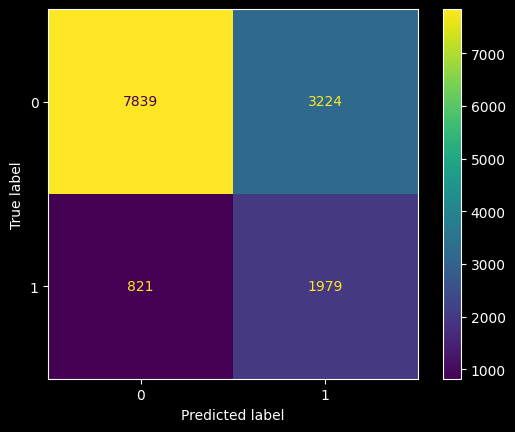

In [20]:
# строим матрицу ошибок
ConfusionMatrixDisplay(confusion_matrix(df['smoking'], df['pred_smoking'])).plot();

In [21]:
# посмотрим значения метрик, которые получились
print(classification_report(df['smoking'], df['pred_smoking']))

              precision    recall  f1-score   support

           0       0.91      0.71      0.79     11063
           1       0.38      0.71      0.49      2800

    accuracy                           0.71     13863
   macro avg       0.64      0.71      0.64     13863
weighted avg       0.80      0.71      0.73     13863



In [22]:
roc_auc_score(df['smoking'], df['pred_smoking'])

0.7076819288232331

In [23]:
# загружаем данные для проверки
test = pd.read_csv(r'/kaggle/input/leopard-challenge-classification/test.csv')
test.head()

,ID,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar
0,19200,40,170,75,87.0,1.2,1.0,1.0,1.0,140.0,...,129.0,16.4,1.0,1.1,25.0,58.0,43.0,Y,0,Y
1,7784,25,170,65,78.4,0.9,0.9,1.0,1.0,118.0,...,91.0,11.9,1.0,0.9,33.0,66.0,22.0,Y,0,N
2,11682,50,180,105,109.3,0.9,1.0,1.0,1.0,130.0,...,62.0,15.4,1.0,0.9,19.0,24.0,32.0,Y,0,Y
3,9949,60,160,60,81.0,0.5,0.5,1.0,1.0,118.0,...,108.0,16.2,1.0,1.2,34.0,37.0,26.0,Y,0,Y
4,9378,45,175,70,83.0,0.9,1.0,1.0,1.0,130.0,...,84.0,15.2,1.0,0.7,27.0,25.0,26.0,Y,0,N


In [24]:
# предсказываем курящих
test['smoking'] = model.predict(test[X])
test.head(5)

,ID,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking
0,19200,40,170,75,87.0,1.2,1.0,1.0,1.0,140.0,...,16.4,1.0,1.1,25.0,58.0,43.0,Y,0,Y,1
1,7784,25,170,65,78.4,0.9,0.9,1.0,1.0,118.0,...,11.9,1.0,0.9,33.0,66.0,22.0,Y,0,N,0
2,11682,50,180,105,109.3,0.9,1.0,1.0,1.0,130.0,...,15.4,1.0,0.9,19.0,24.0,32.0,Y,0,Y,1
3,9949,60,160,60,81.0,0.5,0.5,1.0,1.0,118.0,...,16.2,1.0,1.2,34.0,37.0,26.0,Y,0,Y,0
4,9378,45,175,70,83.0,0.9,1.0,1.0,1.0,130.0,...,15.2,1.0,0.7,27.0,25.0,26.0,Y,0,N,1


In [25]:
# средняя получилась совсем не такая, почти 38%
test['smoking'].mean()

0.3773140356782228

In [26]:
# выгружаем данные
result_df = test.loc[:, ['ID', 'smoking']]
result_df.to_csv(r'ptv_submission.csv', index=False)